# GPUs

In the introduction to this book we discussed the rapid growth of computation over the past two decades. In a nutshell, GPU performance has increased by a factor of 1000 every decade since 2000. This offers great opportunity but it also suggests a significant need to provide such performance.

|Decade|Dataset|Memory|Floating Point Calculations per Second|
|:--|:-|:-|:-|
|1970|100 (Iris)|1 KB|100 KF (Intel 8080)|
|1980|1 K (House prices in Boston)|100 KB|1 MF (Intel 80186)|
|1990|10 K (optical character recognition)|10 MB|10 MF (Intel 80486)|
|2000|10 M (web pages)|100 MB|1 GF (Intel Core)|
|2010|10 G (advertising)|1 GB|1 TF (NVIDIA C2050)|
|2020|1 T (social network)|100 GB|1 PF (NVIDIA DGX-2)|

In this section we begin to discuss how to harness this compute performance for your research. First by using single GPUs and at a later point, how to use multiple GPUs and multiple servers (with multiple GPUs). You might have noticed that PyTorch Tensor looks almost identical to NumPy. But there are a few crucial differences. One of the key features that differentiates PyTorch from NumPy is its support for diverse hardware devices.

In PyTorch, every tensor has a device. As we will discover, this just indicates that the computation is being executed on this device(earlier we saw this was always a CPU). Other deivces might be various GPUs. Things can get even hairier when we deploy jobs across multiple servers. By assigning arrays to devices intelligently, we can minimize the time spent transferring data between devices. For example, when training neural networks on a server with a GPU, we typically prefer for the model’s parameters to live on the GPU.

In short, for complex neural networks and large-scale data, using only CPUs for computation may be inefficient. In this section, we will discuss how to use a single NVIDIA GPU for calculations. First, make sure you have at least one NVIDIA GPU installed. Then, [download CUDA](https://developer.nvidia.com/cuda-downloads) and follow the prompts to set the appropriate path. Once these preparations are complete, the `nvidia-smi` command can be used to view the graphics card information.


In [1]:
!nvidia-smi

Mon Jun  3 15:18:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 53%   63C    P2    78W / 250W |  10755MiB / 11178MiB |     33%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
|  0%   31C    P0    63W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

Next, we need to confirm that the GPU version of PyTorch is installed. If a CPU version of PyTorch is already installed, we need to uninstall it first. For example, use the `pip uninstall torch` command, then install the corresponding PyTorch version according to the CUDA version. Assuming you have CUDA 10.0 installed, you can install the PyTorch version that supports CUDA 10.0. To run the programs in this section, you need at least two GPUs.

Note that this might be extravagant for most desktop computers but it is easily available in the cloud, e.g. by using the AWS EC2 multi-GPU instances. Almost all other sections do *not* require multiple GPUs. Instead, this is simply to illustrate how data flows between different devices.

## Computing Devices

PyTorch can specify devices, such as CPUs and GPUs, for storage and calculation. By default, PyTorch creates data in the main memory and then uses the CPU to calculate it. In PyTorch, the CPU and GPU can be indicated by `type = 'cpu'` and `type = 'gpu'`. It should be noted that `torch.device('cpu')` (or any integer in the parentheses) means all physical CPUs and memory. This means that PyTorch's calculations will try to use all CPU cores. However, `torch.device('cuda:0')` only represents one graphic card and the corresponding graphic memory. If there are multiple GPUs, we use `torch.device('cuda:i')` to represent the $i$-th GPU ($i$ starts from 0).

In [2]:
import torch
import torch.nn as nn

torch.device('cpu'), torch.cuda.device('cuda'), torch.cuda.device('cuda:1')

(device(type='cpu'),
 <torch.cuda.device at 0x7f25e5404780>)

## Tensors and GPUs

By default, Tensor objects are created on the CPU. Therefore, we will see the `type='cpu'` identifier each time we use `.device` attribute.  We can use the `device` property of Tensor to view the device where the Tensor is located. It is important to note that whenever we want to operate on multiple terms they need to be in the same device. For instance, if we sum two variables, we need to make sure that both arguments are on the same device - otherwise PyTorch would not know where to store the result or even how to decide where to perform the computation.

In [3]:
x = torch.tensor([1, 2, 3])
x.device

device(type='cpu')

### Storage on the GPU

There are several ways to store a Tensor on the GPU. For example, we can specify a storage device with the `device` parameter when creating a Tensor. Next, we create the Tensor variable `a` on `gpu(0)`. Notice that when printing `a`, the device information becomes `device='cuda:0'`. The Tensor created on a GPU only consumes the memory of this GPU. We can use the `nvidia-smi` command to view GPU memory usage. In general, we need to make sure we do not create data that exceeds the GPU memory limit.

In [4]:
x = torch.ones((2, 3), device=torch.device('cuda:0'))
x

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

Assuming you have at least two GPUs, the following code will create a random array on `gpu(1)`.

In [5]:
y = torch.randn(size=(2, 3), device=torch.device('cuda:1'))
y

tensor([[ 1.9060e-03, -2.4239e-01, -4.1872e-01],
        [ 2.8501e+00,  4.0416e-01, -2.9519e-01]], device='cuda:1')

### Copying

If we want to compute $\mathbf{x} + \mathbf{y}$ we need to decide where to perform this operation. For instance, we can transfer $\mathbf{x}$ to `gpu(1)` and perform the operation there. **Do not** simply add `x + y` since this will result in an exception. The runtime engine wouldn't know what to do, it cannot find data on the same device and it fails.

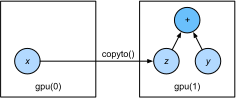

In [6]:
from IPython.display import SVG
SVG(filename="../img/copyto.svg")

Instead of `copyto` as shown in image, in PyTorch we simply use `copy_` to copy the tensor to the target device.

In [7]:
z = x.cuda(1)
print(x)
print(z)

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')
tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:1')


This copies the data to another device such that we can add them. Since $\mathbf{y}$ lives on the second GPU we need to move $\mathbf{x}$ there before we can add the two.

Now that the data is on the same GPU (both $\mathbf{z}$ and $\mathbf{y}$ are), we can add them up. In such cases PyTorch places the result on the same device as its constituents. In our case that is `gpu(1)`.

In [8]:
y + z

tensor([[1.0019, 0.7576, 0.5813],
        [3.8501, 1.4042, 0.7048]], device='cuda:1')

Imagine that your variable z already lives on your second GPU (gpu(1)). What happens if we call `z.copy_(z)`? It will make a copy and allocate new memory, even though that variable already lives on the desired device!

In [9]:
z.copy_(z)
z

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:1')

In [10]:
x

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

It is important to note that, if the `device` of the source variable and the target variable are consistent, then the `.cuda` function causes the target variable and the source variable to share the memory of the source variable.

In [11]:
y is y.cuda(1)

True

The `copy_` function mutates in place and no copy is made unlike MXNet

In [12]:
y is y.copy_(y)

True

### Watch Out

People use GPUs to do machine learning because they expect them to be fast. But transferring variables between devices is slow. So we want you to be 100% certain that you want to do something slow before we let you do it. If PyTorch just did the copy automatically without crashing then you might not realize that you had written some slow code.

Also, transferring data between devices (CPU, GPUs, other machines) is something that is *much slower* than computation. It also makes parallelization a lot more difficult, since we have to wait for data to be sent (or rather to be received) before we can proceed with more operations. This is why copy operations should be taken with great care. As a rule of thumb, many small operations are much worse than one big operation. Moreover, several operations at a time are much better than many single operations interspersed in the code (unless you know what you're doing). This is the case since such operations can block if one device has to wait for the other before it can do something else. It's a bit like ordering your coffee in a queue rather than pre-ordering it by phone and finding out that it's ready when you are.

Lastly, when we print Tensor data or convert Tensor to NumPy format, if the data is not in main memory, PyTorch will copy it to the main memory first, resulting in additional transmission overhead. Even worse, it is now subject to the dreaded Global Interpreter Lock which makes everything wait for Python to complete.

## PyTorch and GPUs

Similar to Tensors, PyTorch's model can specify devices through the `.to(device)` parameter during initialization. The following code initializes the model parameters on the GPU (we will see many more examples of how to run models on GPUs in the following, simply since they will become somewhat more compute intensive).

In [13]:
net = nn.Sequential(nn.Linear(3,1))
net = net.to(device='cuda:0')

When the input is a Tensor on the GPU, PyTorch will calculate the result on the same GPU.

In [14]:
net(x)

tensor([[1.3683],
        [1.3683]], device='cuda:0', grad_fn=<AddmmBackward>)

Let us confirm that the model parameters are stored on the same GPU.

In [15]:
for param in net[0].parameters():
    print(param)

Parameter containing:
tensor([[0.3571, 0.4750, 0.5428]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0066], device='cuda:0', requires_grad=True)


In short, as long as all data and parameters are on the same device, we can learn models efficiently. In the following we will see several such examples.

## Summary

* PyTorch can specify devices for storage and calculation, such as CPU or GPU. By default, PyTorch creates data in the main memory and then uses the CPU to calculate it.
* PyTorch requires all input data for calculation to be **on the same device**, be it CPU or the same GPU.
* You can lose significant performance by moving data without care. A typical mistake is as follows: computing the loss for every minibatch on the GPU and reporting it back to the user on the commandline (or logging it in a NumPy array) will trigger a global interpreter lock which stalls all GPUs. It is much better to allocate memory for logging inside the GPU and only move larger logs.

## Exercises

1. Try a larger computation task, such as the multiplication of large matrices, and see the difference in speed between the CPU and GPU. What about a task with a small amount of calculations?
1. How should we read and write model parameters on the GPU?
1. Measure the time it takes to compute 1000 matrix-matrix multiplications of $100 \times 100$ matrices and log the matrix norm $\mathrm{tr} M M^\top$ one result at a time vs. keeping a log on the GPU and transferring only the final result.
1. Measure how much time it takes to perform two matrix-matrix multiplications on two GPUs at the same time vs. in sequence on one GPU (hint - you should see almost linear scaling).

## References

[1] CUDA download address. https://developer.nvidia.com/cuda-downloads